# Advanced Lane Detection


In [1]:
### Camera Calibration via images

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

images_path=glob.glob('D:\SankarStuff\SDC_ND\CarND-Advanced-Lane-Lines\camera_cal\Calibration*.jpg')

nx=9
ny=6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

for img_path in images_path:
    
    fname = img_path
    img = cv2.imread(fname)
    
    # prepare object points
    
    nx = 9#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:        
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners        
        out=cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        cv2.imshow('img',out)
        cv2.waitKey(500)
        
        
cv2.destroyAllWindows()

## Calibrate the camera using all imgpoints and objpoints obtained above

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


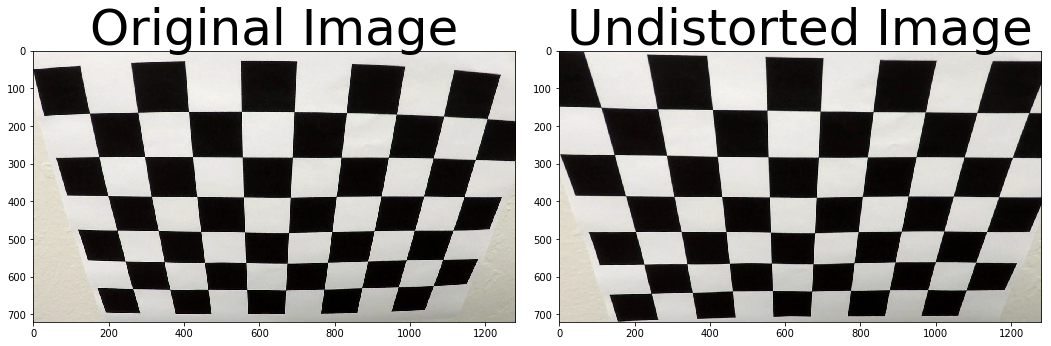

In [2]:
# Undistort images 

img = mpimg.imread('D:\SankarStuff\SDC_ND\CarND-Advanced-Lane-Lines\camera_cal\Calibration2.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


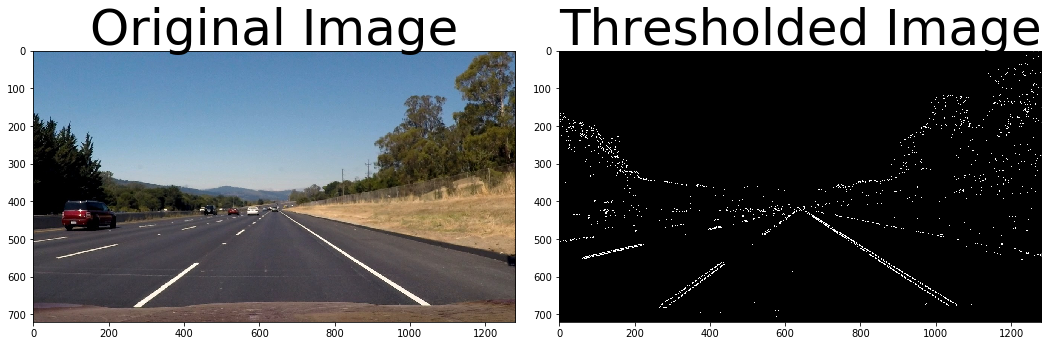

In [9]:
## Lane detection - step 1 - thresholding with sobel operators

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

img_BGR=cv2.imread('D:/SankarStuff/SDC_ND/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg')
img=cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, 'x',20,100)
grady = abs_sobel_thresh(img, 'y',20,100)
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(400,1000))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/2))

gradient_binary = np.zeros_like(dir_binary)
gradient_binary[(gradx == 1) & (dir_binary == 1)] = 1 ## magnitude/sobely did not add much value

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(gradient_binary,cmap='gray') ## note the cmap argument for displaying grayscale image matplotlib
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



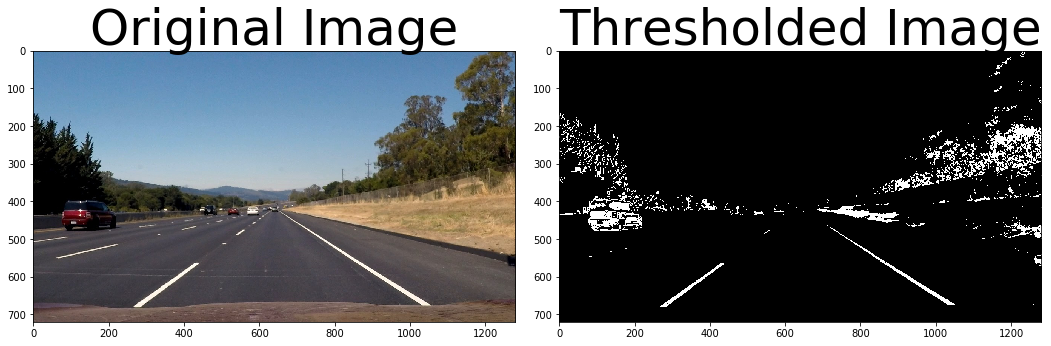

In [17]:
## Lane detection - step 2 - thresholding with color spaces (HLS - Hue, Lightness and Saturation)

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

img_BGR=cv2.imread('D:/SankarStuff/SDC_ND/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg')
img=cv2.cvtColor(img_BGR, cv2.COLOR_BGR2RGB)

hls_binary = hls_select(img, thresh=(120, 255)) ## operating on the s-channel which works best for white/yellow lines

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary,cmap='gray') ## note the cmap argument for displaying grayscale image matplotlib
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

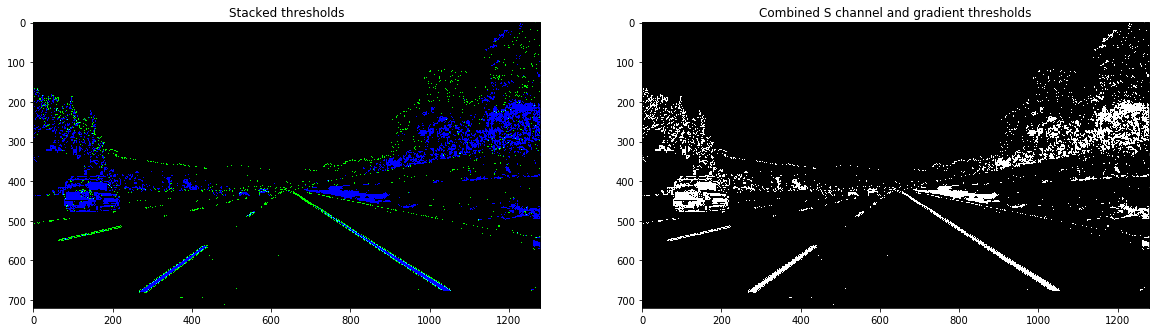

In [18]:
### Combine gradient (sobelx) and color (s-channel thresholds)

color_binary = np.dstack(( np.zeros_like(gradient_binary), gradient_binary, hls_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(gradient_binary)
combined_binary[(gradient_binary == 1) | (hls_binary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds') # green is the gradient threshold component and blue is color threshold component
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')
plt.show()

In [ ]:
### Perspective transform

